In [118]:
# pip install arch

Note: you may need to restart the kernel to use updated packages.


In [1]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.stattools import grangercausalitytests

# Import other packages
import arch.unitroot as ut

In [2]:
def process_data1(df,column,variable,rename):
    df = df[df[column] == variable]
    df = df.dropna()
    df = df[df['VALUE']!=0]
    df.rename(columns = {'VALUE':rename,'REF_DATE':'DATE'}, inplace = True)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['DATE'] = df['DATE'].dt.to_period('Q')
    df = df.groupby('DATE').mean()
    return df    

In [3]:
#************ CANADA interest rate *********************
# Data source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1010013901
# Download options / CSV download entire table 
# downloads file 10100139.csv (extract from zip file)
#
# Create Stata variables:
# rate_target_can  - interest rate, overnight target, Canada, quarterly
# rate_t3m_can     - treasury bills, 3 month rate, Canada, quarterly

CAN_int = pd.read_csv("10100139.csv") 
CAN_int = CAN_int[['REF_DATE','Financial market statistics','VALUE']]

rate_target_can = process_data1(CAN_int,'Financial market statistics','Target rate','rate_target_can')
rate_t3m_can = process_data1(CAN_int,'Financial market statistics','Treasury Bills, 3-month','rate_t3m_can')

In [4]:
#*********** CANADA CPI *********************
# Data source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810025601&request_locale=en
# Download button / CSV download entire table 
# downloads file 18100256.csv (extract from zip file)
#
# Create Stata variables:
# cpi_can - Consumer Price Index (CPI), all-items excluding eight of the most volatile components as defined by the Bank of Canada (2002=100)
# cpipc_comm_can - Measure of core inflation based on a factor model, CPI-common (year-over-year percent change)
# cpipc_med_can  - Measure of core inflation based on a weighted median approach, CPI-median (year-over-year percent change)
# cpipc_trim_can - Measure of core inflation based on a trimmed mean approach, CPI-trim (year-over-year percent change)

CAN_CPI = pd.read_csv("18100256.csv")
CAN_CPI = CAN_CPI[['REF_DATE','Alternative measures','VALUE']]

cpi_can = process_data1(CAN_CPI,'Alternative measures','Consumer Price Index (CPI), all-items excluding eight of the most volatile components as defined by the Bank of Canada','cpi_can')
cpipc_comm_can = process_data1(CAN_CPI,'Alternative measures','Measure of core inflation based on a factor model, CPI-common (year-over-year percent change)','cpipc_comm_can')
cpipc_med_can = process_data1(CAN_CPI,'Alternative measures','Measure of core inflation based on a weighted median approach, CPI-median (year-over-year percent change)','cpipc_med_can')
cpipc_trim_can = process_data1(CAN_CPI,'Alternative measures', 'Measure of core inflation based on a trimmed mean approach, CPI-trim (year-over-year percent change)','cpipc_trim_can')


In [5]:
#*********** CANADA GDP *********************
# Data source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610010401
# Download button / CSV download entire table 
# downloads file 36100104.csv (extract from zip file)
#
# Create Stata variables:
# gdp_can - GDP Canada, consumption based, chained (2012) dollars, quarterly

CAN_GDP = pd.read_csv("36100104.csv")
CAN_GDP = CAN_GDP[CAN_GDP['Prices']=="Chained (2012) dollars"]
CAN_GDP = CAN_GDP[['REF_DATE','Estimates','VALUE']]

gdp_can = process_data1(CAN_GDP,'Estimates','Final consumption expenditure','gdp_can')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
#*********** CANADA Output gap *********************
# stored in file output_gap_can.txt
# Data source: http://www.bankofcanada.ca/rates/indicators/capacity-and-inflation-pressures/product-market-definitions/product-market-historical-data/
#
# Create Stata variables:
# gap_int_can - output gap, Integrated
# gap_fil_can - output gap, Extended multivariate filter

gap_can = pd.read_csv("output_gap_can.txt",delimiter='\t',index_col=False)

gap_can['time_q'] = gap_can['time_q'].str.replace('-', 'Q')
gap_can['time_q'] = pd.to_datetime(gap_can['time_q'])
gap_can['time_q'] = gap_can['time_q'].dt.to_period('Q')

gap_can.rename(columns = {'integrated':'gap_int_can','filter':'gap_fil_can','time_q':'DATE'}, inplace = True)
gap_can.set_index('DATE',inplace=True)

In [7]:
#*********** U.S. Fed funds *********************
# Data source: https://fred.stlouisfed.org/series/FEDFUNDS/downloaddata?cid=118
# Edit Graph - Modify Frequency - Quarterly (Average)
# Download CSV (data)
# downloads file FEDFUNDS.csv

fed_us = pd.read_csv('FEDFUNDS.csv')

fed_us['DATE'] = pd.to_datetime(fed_us['DATE'])
fed_us['DATE'] = fed_us['DATE'].dt.to_period('Q')
fed_us.rename(columns = {'FEDFUNDS':'fed_us'}, inplace = True)
fed_us.set_index('DATE',inplace=True)

In [8]:
#*********** U.S. CPI *********************
# Data source: https://fred.stlouisfed.org/series/PCEPI/downloaddata
# Edit Graph - Modify Frequency - Quarterly (Average)
# Download CSV (data)
# downloads file PCEPI.csv

cpi_us = pd.read_csv('PCEPI.csv')
cpi_us['DATE'] = pd.to_datetime(cpi_us['DATE'])
cpi_us['DATE'] = cpi_us['DATE'].dt.to_period('Q')
cpi_us.rename(columns = {'PCEPI':'cpi_us'}, inplace = True)
cpi_us.set_index('DATE',inplace=True)

In [9]:
#*********** U.S. GDP *********************
# Data source: https://fred.stlouisfed.org/series/GDP/downloaddata 
# Download CSV (data)
# downloads file GDP.csv
#
# Deflator:
# Data source: https://fred.stlouisfed.org/series/GDPDEF/downloaddata
# Download CSV (data)
# downloads file GDPDEF.csv

GDP = pd.read_csv('GDP.csv')
GDPDEF = pd.read_csv('GDPDEF.csv')

gdp_us = pd.merge(GDP, GDPDEF, on='DATE')
gdp_us['gdp_us'] = gdp_us['GDP']/gdp_us['GDPDEF']
gdp_us.drop(columns=['GDP','GDPDEF'], inplace=True)
gdp_us['DATE'] = pd.to_datetime(gdp_us['DATE'])
gdp_us['DATE'] = gdp_us['DATE'].dt.to_period('Q')
gdp_us.set_index('DATE',inplace=True)

In [10]:
#*********** U.S. output gap *********************
# Data source: https://fred.stlouisfed.org/series/NGDPPOT
# SPECIFY MAXIMUM RANGE OF DATA (Max)
# Download CSV (data)
# downloads file NGDPPOT.csv

NGDPPOT = pd.read_csv('NGDPPOT.csv')
NGDPPOT = pd.merge(NGDPPOT, GDPDEF, on='DATE')
NGDPPOT['ngdppot'] = NGDPPOT['NGDPPOT']/NGDPPOT['GDPDEF']
NGDPPOT['DATE'] = pd.to_datetime(NGDPPOT['DATE'])
NGDPPOT['DATE'] = NGDPPOT['DATE'].dt.to_period('Q')

gap_us = pd.merge(NGDPPOT, gdp_us, on='DATE')
gap_us['gap_us'] = 100*(gap_us['gdp_us'] - gap_us['ngdppot'])/gap_us['ngdppot']
gap_us.drop(columns=['NGDPPOT','GDPDEF','ngdppot','gdp_us'], inplace=True)
gap_us.set_index('DATE',inplace=True)

In [11]:
#*********** U.S. unemployment *********************
# Data source: https://fred.stlouisfed.org/series/UNRATE/downloaddata
# Edit Graph - Modify Frequency - Quarterly (Average)
# Download CSV (data)
# downloads file UNRATE.csv

un_us = pd.read_csv('UNRATE.csv')
un_us['DATE'] = pd.to_datetime(un_us['DATE'])
un_us['DATE'] = un_us['DATE'].dt.to_period('Q')
un_us.rename(columns = {'UNRATE':'un_us'}, inplace = True)
un_us.set_index('DATE',inplace=True)

In [12]:
#************ merge variables *****************
df = rate_target_can
for i in (rate_t3m_can, cpi_can, cpipc_comm_can, cpipc_med_can, cpipc_trim_can, gdp_can, gap_can, fed_us, cpi_us, gdp_us, un_us, gap_us):
    df = pd.merge(df,i,on='DATE')
    
df.index=df.index.to_timestamp()
df =df.astype(float)
df

,rate_target_can,rate_t3m_can,cpi_can,cpipc_comm_can,cpipc_med_can,cpipc_trim_can,gdp_can,gap_int_can,gap_fil_can,fed_us,cpi_us,gdp_us,un_us,gap_us
DATE,,,,,,,,,,,,,,
1992-10-01,7.660714,7.202500,84.033333,2.100000,1.766667,1.700000,845897.0,-2.5,-2.0,3.036667,67.895000,98.345448,7.366667,-2.241689
1993-01-01,5.941468,5.979524,84.600000,2.000000,1.966667,2.033333,846637.0,-2.5,-1.8,3.040000,68.299333,98.509200,7.133333,-2.701459
1993-04-01,4.534722,4.941351,84.833333,1.866667,1.866667,1.866667,849881.0,-2.1,-1.4,3.000000,68.758333,99.083791,7.066667,-2.723884
1993-07-01,4.224609,4.441220,85.400000,1.666667,1.733333,1.833333,850900.0,-1.8,-1.0,3.060000,69.056667,99.555867,6.800000,-2.770507
1993-10-01,4.257137,4.220294,85.966667,1.533333,1.666667,1.766667,852205.0,-2.0,-1.1,2.990000,69.454667,100.909834,6.633333,-2.097460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,1.250000,1.213437,130.866667,1.900000,1.933333,1.966667,1605213.0,-0.1,0.0,1.736667,107.988000,185.981057,3.900000,0.688648
2018-07-01,1.473077,1.463387,131.266667,1.900000,1.966667,2.100000,1611890.0,-0.2,0.5,1.923333,108.413000,187.327923,3.800000,0.911630
2018-10-01,1.685606,1.663226,131.500000,1.900000,1.833333,2.000000,1617239.0,-0.6,0.0,2.220000,108.772000,187.835299,3.800000,0.702117


In [13]:
'''#switch from DATE to DATEQ, please ignore for now
df['DATEQ'] = pd.to_datetime(df.index)
df['DATEQ'] = df['DATEQ'].dt.to_period('Q')
df.set_index('DATEQ', inplace=True)
df
'''

"#switch from DATE to DATEQ, please ignore for now\ndf['DATEQ'] = pd.to_datetime(df.index)\ndf['DATEQ'] = df['DATEQ'].dt.to_period('Q')\ndf.set_index('DATEQ', inplace=True)\ndf\n"

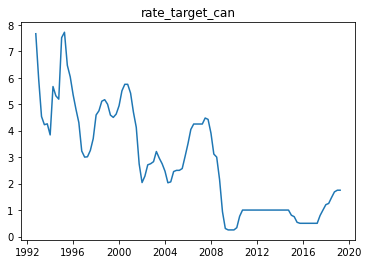

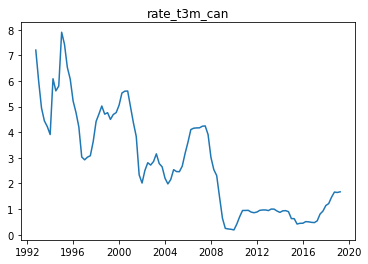

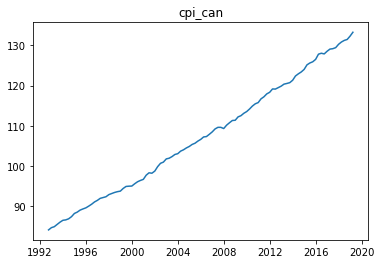

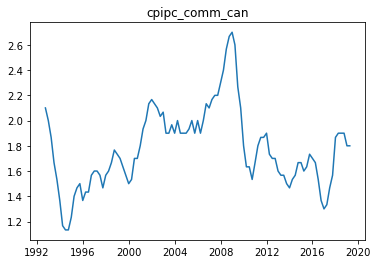

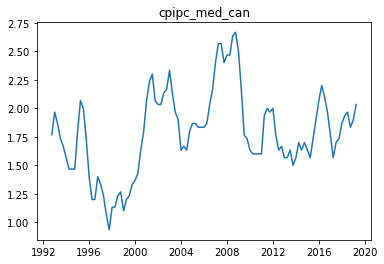

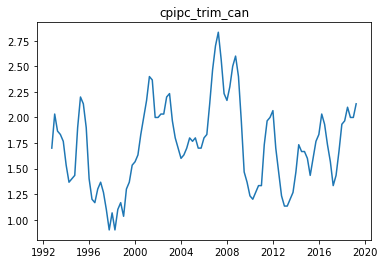

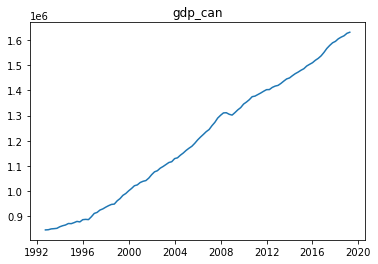

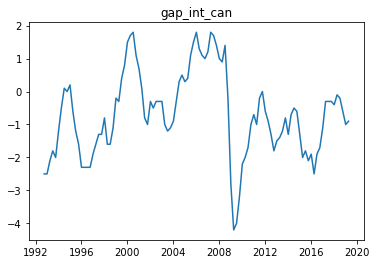

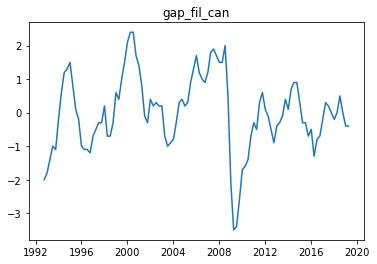

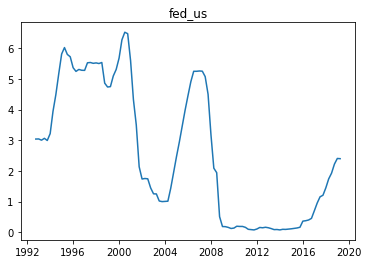

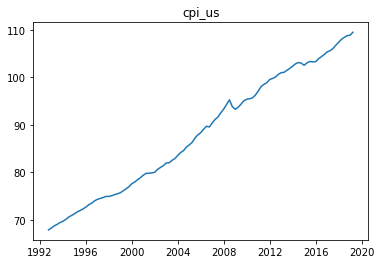

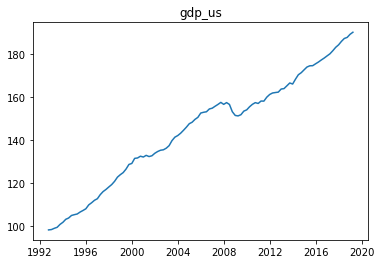

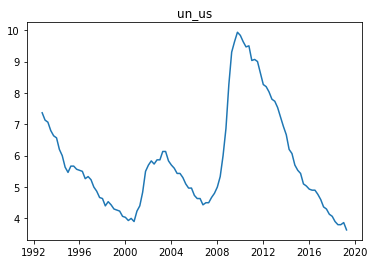

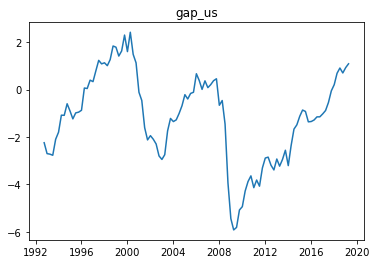

In [14]:
#********** plot variables *************
for i in range(14):
    plt.plot(df[df.columns[i]])
    plt.title(df.columns[i])
    #plt.savefig(df.columns[i]+'.png')
    plt.show()

In [15]:
#********** test for unit root *************
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [16]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rate_target_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1063
 No. Lags Chosen       = 1
 Critical value 1%     = -3.494
 Critical value 5%     = -2.889
 Critical value 10%    = -2.582
 => P-Value = 0.242. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "rate_t3m_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.019
 No. Lags Chosen       = 1
 Critical value 1%     = -3.494
 Critical value 5%     = -2.889
 Critical value 10%    = -2.582
 => P-Value = 0.2783. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "cpi_can" 
    -----------------------------------------------
 Null Hypothes

In [17]:
def PP_test(series, signif=0.05, name=''):
    r = ut.PhillipsPerron(series)
    test_statistic = np.round(r.stat,4)
    p_value = np.round(r.pvalue,4)
        
    # Print Summary
    print(f'    Phillips-Perron Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {test_statistic}')
    
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


In [18]:
for name, column in df.iteritems():
    PP_test(column, name=column.name)
    print('\n')

    Phillips-Perron Test on "rate_target_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5005
 => P-Value = 0.1153. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Phillips-Perron Test on "rate_t3m_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2628
 => P-Value = 0.1843. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Phillips-Perron Test on "cpi_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 2.6153
 => P-Value = 0.9991. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Phillips-Perron Test on "cpipc_comm_can" 
    -----------------

In [19]:
#********** difference variables and test for unit root *************
df_diff1 = df.diff().dropna()
df_diff1.rename(columns = {'rate_target_can': 'D_rate_target_can',
                           'rate_t3m_can': 'D_rate_t3m_can',#
                           'cpi_can': 'D_cpi_can',
                           'cpipc_comm_can': 'D_cpipc_comm_can',#
                           'cpipc_med_can': 'D_cpipc_med_can',#
                           'cpipc_trim_can': 'D_cpipc_trim_can',#
                           'gdp_can': 'D_gdp_can',
                           'gap_int_can': 'D_gap_int_can',
                           'gap_fil_can': 'D_gap_fil_can',
                           'fed_us': 'D_fed_us',
                           'cpi_us': 'D_cpi_us',
                           'gdp_us': 'D_gdp_us',
                           'un_us': 'D_un_us',
                           'gap_us': 'D_gap_us'}, inplace = True)

In [20]:
for name, column in df_diff1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "D_rate_target_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.745
 No. Lags Chosen       = 11
 Critical value 1%     = -3.502
 Critical value 5%     = -2.893
 Critical value 10%    = -2.583
 => P-Value = 0.0035. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "D_rate_t3m_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6808
 No. Lags Chosen       = 0
 Critical value 1%     = -3.494
 Critical value 5%     = -2.889
 Critical value 10%    = -2.582
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "D_cpi_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.

In [21]:
for name, column in df_diff1.iteritems():
    PP_test(column, name=column.name)
    print('\n')

    Phillips-Perron Test on "D_rate_target_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2238
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Phillips-Perron Test on "D_rate_t3m_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4968
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Phillips-Perron Test on "D_cpi_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8853
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Phillips-Perron Test on "D_cpipc_comm_can" 
    -----------------------------------------------
 Null Hypothesis: Data has unit roo

In [22]:
#differenced dataframe
df_diff1

,D_rate_target_can,D_rate_t3m_can,D_cpi_can,D_cpipc_comm_can,D_cpipc_med_can,D_cpipc_trim_can,D_gdp_can,D_gap_int_can,D_gap_fil_can,D_fed_us,D_cpi_us,D_gdp_us,D_un_us,D_gap_us
DATE,,,,,,,,,,,,,,
1993-01-01,-1.719246,-1.222976,0.566667,-0.100000,0.200000,0.333333,740.0,0.0,0.2,0.003333,0.404333,0.163752,-0.233333,-0.459770
1993-04-01,-1.406746,-1.038172,0.233333,-0.133333,-0.100000,-0.166667,3244.0,0.4,0.4,-0.040000,0.459000,0.574590,-0.066667,-0.022425
1993-07-01,-0.310113,-0.500132,0.566667,-0.200000,-0.133333,-0.033333,1019.0,0.3,0.4,0.060000,0.298333,0.472077,-0.266667,-0.046622
1993-10-01,0.032528,-0.220925,0.566667,-0.133333,-0.066667,-0.066667,1305.0,-0.2,-0.1,-0.070000,0.398000,1.353966,-0.166667,0.673047
1994-01-01,-0.418843,-0.311610,0.466667,-0.166667,-0.100000,-0.233333,6226.0,0.8,0.9,0.223333,0.248667,0.979594,-0.066667,0.299919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,0.046154,0.074244,0.566667,0.033333,0.066667,0.033333,10030.0,0.3,0.2,0.290000,0.587667,1.598460,-0.166667,0.480117
2018-07-01,0.223077,0.249950,0.400000,0.000000,0.033333,0.133333,6677.0,-0.1,0.5,0.186667,0.425000,1.346865,-0.100000,0.222981
2018-10-01,0.212529,0.199839,0.233333,0.000000,-0.133333,-0.100000,5349.0,-0.4,-0.5,0.296667,0.359000,0.507376,0.000000,-0.209513


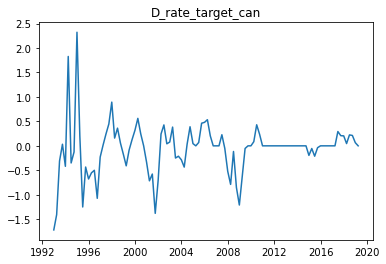

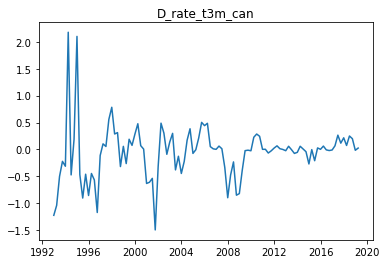

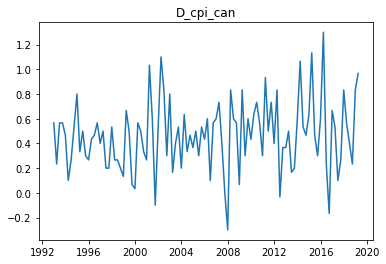

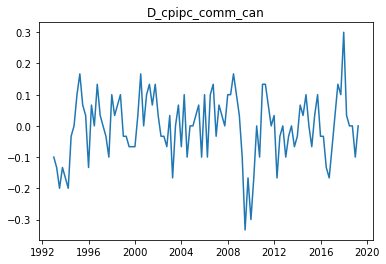

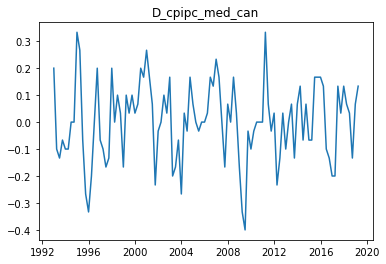

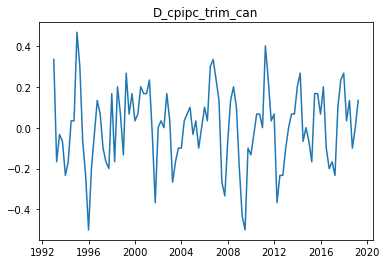

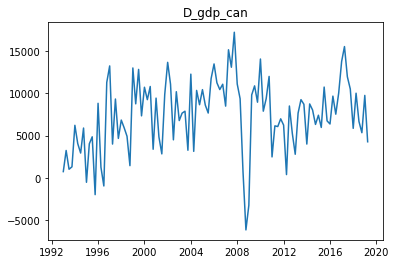

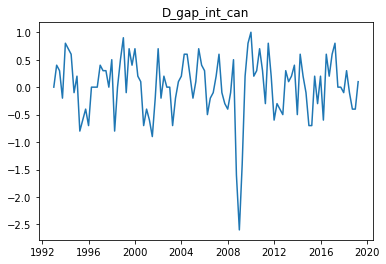

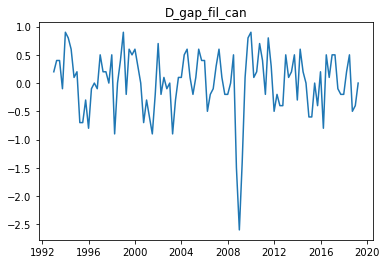

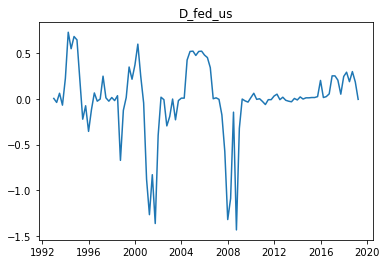

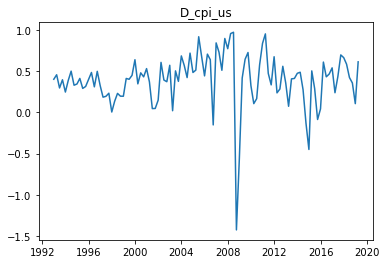

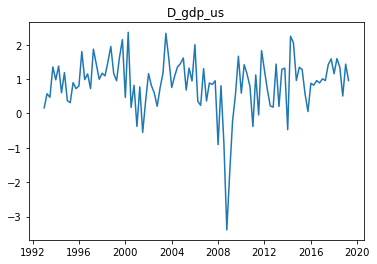

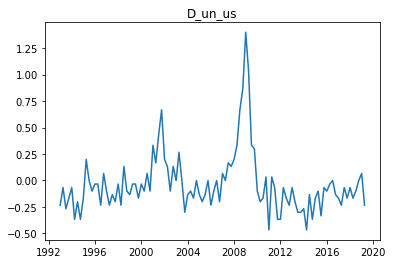

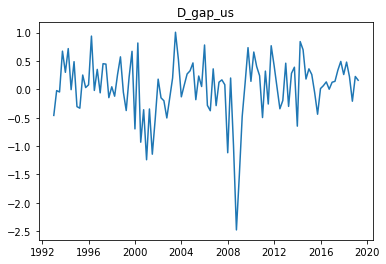

In [23]:
#********** plot differenced variables *************
for i in range(14):
    plt.plot(df_diff1[df_diff1.columns[i]])
    plt.title(df_diff1.columns[i])
    #plt.savefig(df_diff1.columns[i]+'.png')
    plt.show()

In [24]:
#Drop unwanted variable
df_diff1.drop(columns = ['D_rate_t3m_can',
                         'D_cpipc_comm_can',
                         'D_cpipc_med_can',
                         'D_cpipc_trim_can'],inplace = True)

df.drop(columns = ['rate_t3m_can',
                   'cpipc_comm_can',
                   'cpipc_med_can',
                   'cpipc_trim_can'],inplace = True)

In [25]:
# Test for granger causality
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=4
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_diff1, variables = df_diff1.columns)  

,D_rate_target_can_x,D_cpi_can_x,D_gdp_can_x,D_gap_int_can_x,D_gap_fil_can_x,D_fed_us_x,D_cpi_us_x,D_gdp_us_x,D_un_us_x,D_gap_us_x
D_rate_target_can_y,1.0000,0.1744,0.0018,0.0002,0.0004,0.0000,0.3489,0.0005,0.0021,0.0002
D_cpi_can_y,0.3398,1.0000,0.4605,0.6406,0.7336,0.2745,0.2721,0.3495,0.6708,0.4833
D_gdp_can_y,0.4540,0.4445,1.0000,0.6256,0.3626,0.3654,0.1045,0.2926,0.6224,0.6043
D_gap_int_can_y,0.2933,0.1330,0.0368,1.0000,0.1641,0.3090,0.0000,0.0002,0.0002,0.0001
D_gap_fil_can_y,0.2672,0.2699,0.0228,0.0711,1.0000,0.2934,0.0000,0.0002,0.0005,0.0001
D_fed_us_y,0.0100,0.0010,0.0674,0.2613,0.3209,1.0000,0.0255,0.2301,0.2416,0.0701
D_cpi_us_y,0.7165,0.0733,0.0023,0.0277,0.0467,0.0273,1.0000,0.0732,0.0282,0.0549
D_gdp_us_y,0.7247,0.0777,0.0014,0.4002,0.3747,0.0334,0.0692,1.0000,0.0158,0.2802
D_un_us_y,0.6694,0.3143,0.0000,0.0002,0.0001,0.0006,0.0001,0.0000,1.0000,0.0000
D_gap_us_y,0.4582,0.1547,0.0012,0.4040,0.2662,0.0252,0.1487,0.1836,0.0308,1.0000


In [26]:
#model fitting
model = VAR(df_diff1)
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, May, 2021
Time:                     00:43:00
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -4.28346
Nobs:                     105.000    HQIC:                  -5.93715
Log likelihood:          -1009.04    FPE:                0.000862148
AIC:                     -7.06380    Det(Omega_mle):     0.000318343
--------------------------------------------------------------------
Results for equation D_rate_target_can
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.196310         0.164329           -1.195           0.232
L1.D_rate_target_can         0.100184         0.092931            1.078           0.281
L1.D_cpi_can        

In [27]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_diff1.values[-lag_order:]
forecast_input

1


array([[ 0.00000000e+00,  9.66666667e-01,  4.27500000e+03,
         1.00000000e-01,  0.00000000e+00, -6.66666667e-03,
         6.16333333e-01,  9.57649810e-01, -2.33333333e-01,
         1.60090700e-01]])

In [28]:
# Forecast (next 8 quarter)
num_q = 8
fc = model_fitted.forecast(y=forecast_input, steps=num_q)
df_forecast = pd.DataFrame(fc, index=pd.date_range(start=df.index[-1], periods=num_q+1, freq='QS-OCT')[1:], columns=df_diff1.columns)
df_forecast

,D_rate_target_can,D_cpi_can,D_gdp_can,D_gap_int_can,D_gap_fil_can,D_fed_us,D_cpi_us,D_gdp_us,D_un_us,D_gap_us
2019-07-01,-0.102587,0.452429,5784.376424,0.156763,0.142938,-0.031873,0.296725,0.785801,-0.076813,0.038449
2019-10-01,-0.067888,0.456071,6700.577732,-0.006026,-0.000982,0.029710,0.315703,0.860920,-0.045389,0.062619
2020-01-01,-0.026371,0.463998,7166.287950,-0.016261,-0.017021,0.047974,0.372465,0.884013,-0.044155,0.063413
2020-04-01,-0.015088,0.463906,7376.567128,0.008988,0.006870,0.037818,0.393896,0.894975,-0.046486,0.063298
2020-07-01,-0.014784,0.462973,7454.801629,0.022724,0.020868,0.024340,0.398351,0.894002,-0.047312,0.057880
2020-10-01,-0.018774,0.462573,7477.392688,0.024990,0.023344,0.013278,0.397912,0.890278,-0.045629,0.051903
2021-01-01,-0.024055,0.462339,7484.166689,0.023414,0.021678,0.004902,0.396654,0.886206,-0.042640,0.046717
2021-04-01,-0.028954,0.462157,7488.234399,0.021440,0.019504,-0.001262,0.395425,0.882454,-0.039502,0.042622


In [29]:
# invert back to get the original data series
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = pd.DataFrame(index=df_forecast.index)
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_forecast['D_'+str(col)].cumsum()
    return df_fc

In [30]:
df_results = invert_transformation(df, df_forecast)        
df_results

,rate_target_can_forecast,cpi_can_forecast,gdp_can_forecast,gap_int_can_forecast,gap_fil_can_forecast,fed_us_forecast,cpi_us_forecast,gdp_us_forecast,un_us_forecast,gap_us_forecast
2019-07-01,1.647413,133.752429,1.637068e+06,-0.743237,-0.257062,2.364794,109.792392,191.016432,3.556520,1.127168
2019-10-01,1.579525,134.208501,1.643769e+06,-0.749263,-0.258044,2.394504,110.108095,191.877352,3.511131,1.189787
2020-01-01,1.553154,134.672498,1.650935e+06,-0.765524,-0.275065,2.442478,110.480560,192.761365,3.466976,1.253199
2020-04-01,1.538066,135.136404,1.658312e+06,-0.756536,-0.268195,2.480296,110.874456,193.656340,3.420490,1.316497
2020-07-01,1.523283,135.599377,1.665767e+06,-0.733812,-0.247327,2.504636,111.272807,194.550342,3.373177,1.374378
2020-10-01,1.504509,136.061951,1.673244e+06,-0.708823,-0.223983,2.517914,111.670719,195.440620,3.327548,1.426281
2021-01-01,1.480453,136.524290,1.680728e+06,-0.685409,-0.202305,2.522816,112.067374,196.326826,3.284909,1.472997
2021-04-01,1.451500,136.986446,1.688216e+06,-0.663969,-0.182802,2.521554,112.462799,197.209281,3.245407,1.515619


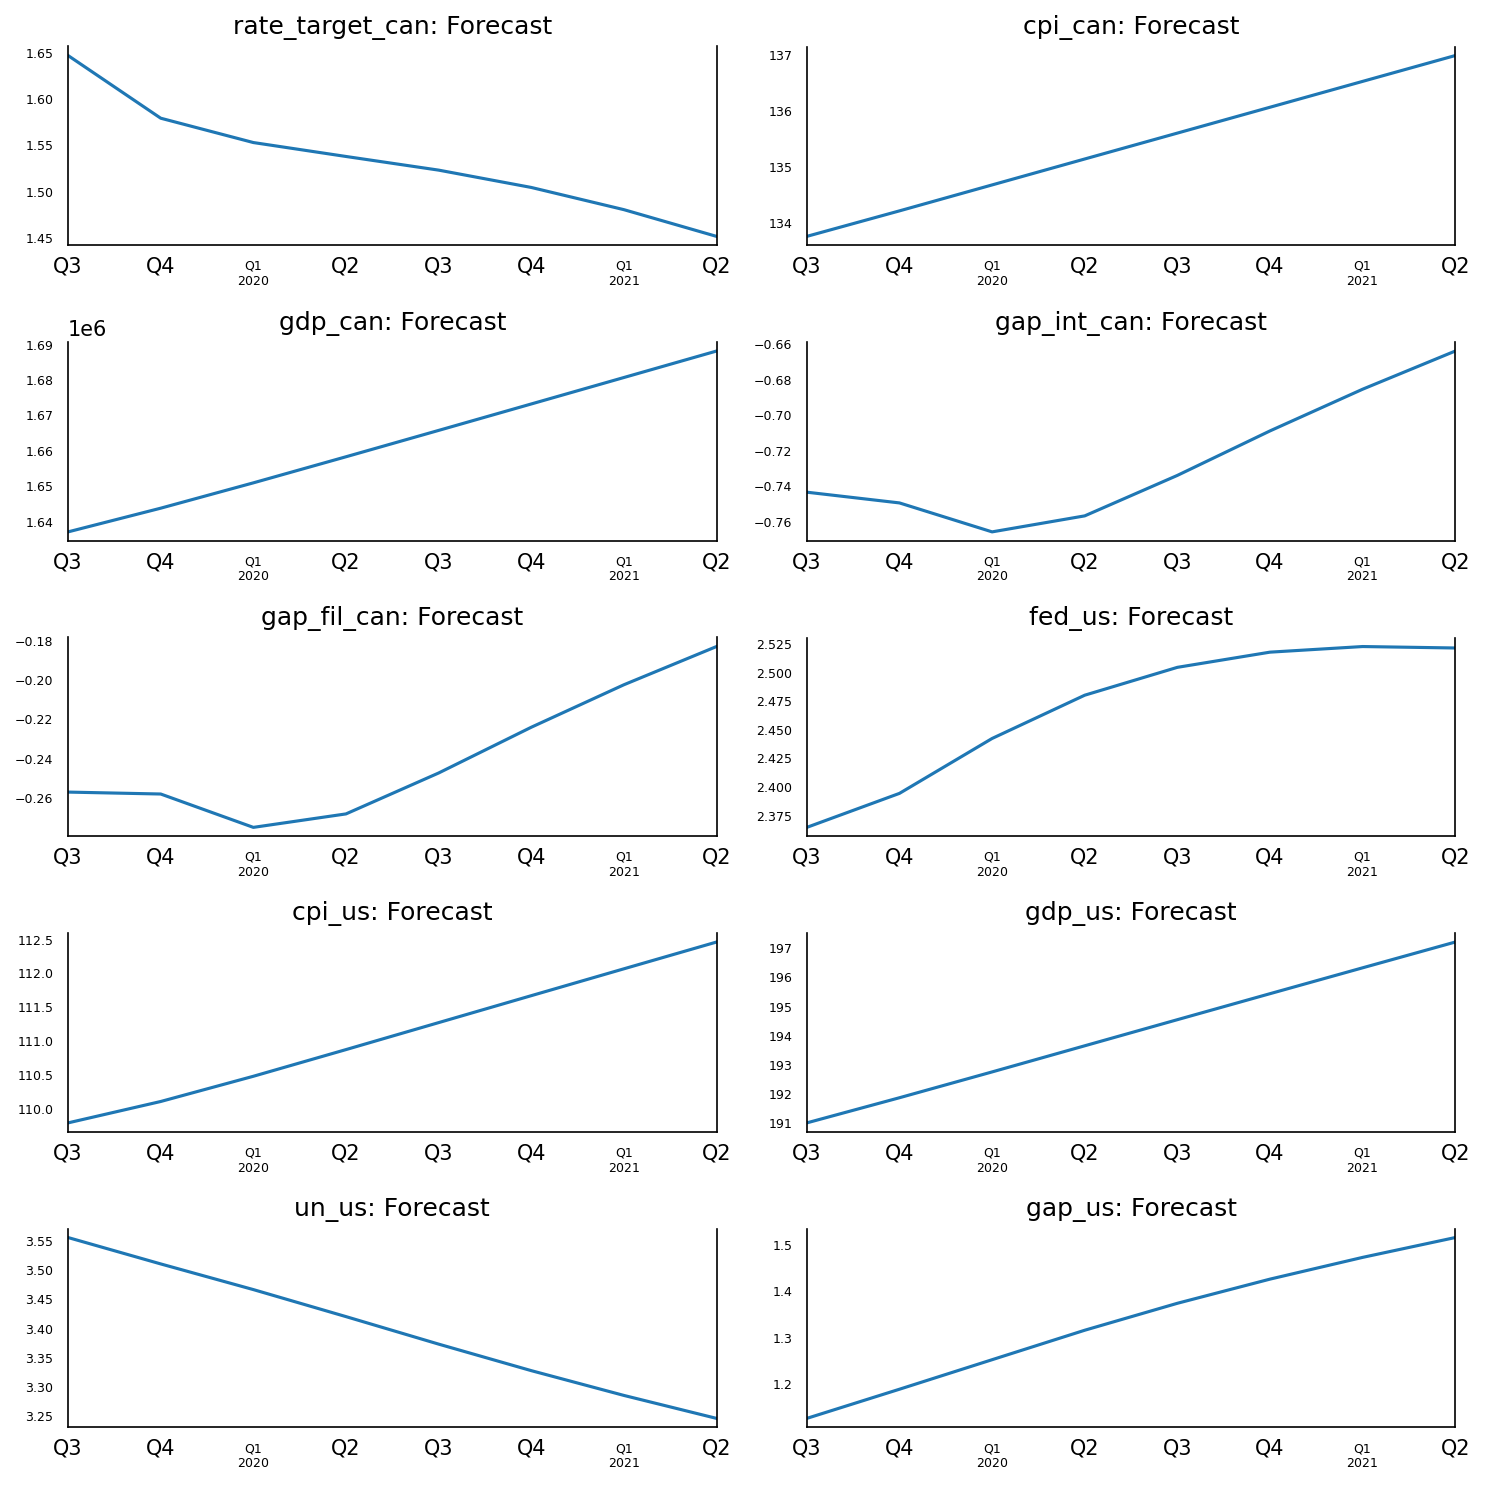

In [31]:
#Plot the forcasted time series
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=False, ax=ax).autoscale(axis='x',tight=True)
    
    ax.set_title(col + ": Forecast")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();